# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [1]:
#Name
ModelName = 'titanic_propensity_survive'

#Setting the model target variable name
VarTarget = 'Survived'
VarId = 'PassengerId'
VarDate = 'ReferenceDate' 

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

CAT = ['Pclass'
,'Embarked'
,'cabine_prefix'
,'Ticket_str'
,'NameTitle']

#float
NUM = ['Fare'
,'SibSp'
,'Parch'
,'Age_Mean'
,'Ticket_int']
selected_features = CAT + NUM

# 2. Import Libraries

In [2]:
# !pip -q install -r requirements.txt

In [3]:
try:
    import sys
    sys.path.append('/anaconda/envs/azureml_py38/lib/python3.8/site-packages')    
except:
    pass

In [4]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [5]:
dataprep_df_full = pd.read_csv('./titanic/dataprep_df.csv')

In [6]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [7]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(int)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

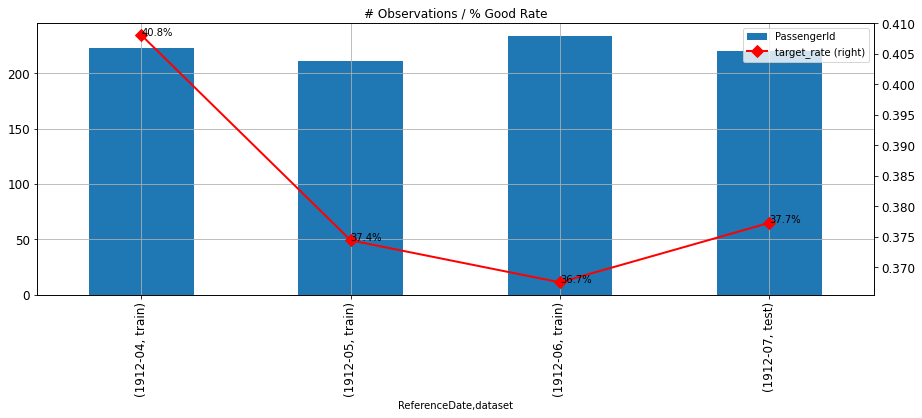

In [8]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'dataset']].groupby(by=[VarDate, 'dataset']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]

dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

## 3.1 Treatment of Numeric Missing Data

In [9]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [10]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [9]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 Traning Models with H2O AutoML

## 4.2.1 Creating context and H2O and Importing data into the H2O context

In [10]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdodg3k5g
  JVM stdout: /tmp/tmpdodg3k5g/h2o_azureuser_started_from_python.out
  JVM stderr: /tmp/tmpdodg3k5g/h2o_azureuser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,14 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,4 months and 23 days !!!
H2O_cluster_name:,H2O_from_python_azureuser_hw2y83
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,982 Mb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [11]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "train"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 604
Validation: 64


In [12]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 220


## 4.2.2 Train the H2O Champion algorithm with new data

In [13]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='h2o_champion_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o_champion = H2OGradientBoostingEstimator(model_id='%s%s_%s' % (vModel, ModelId, str(dt.datetime.now())[:19].replace('-',"").replace(':',"").replace(' ',"_")),
                                    nfolds= 5,
                                    keep_cross_validation_models= False,
                                    keep_cross_validation_predictions= True,
                                    keep_cross_validation_fold_assignment= False,
                                    score_each_iteration= False,
                                    score_tree_interval= 5,
                                    fold_assignment='Modulo',
                                    fold_column= None,
                                    ignore_const_cols= True,
                                    offset_column= None,
                                    weights_column= None,
                                    balance_classes= False,
                                    class_sampling_factors= None,
                                    max_after_balance_size= 5.0,
                                    max_confusion_matrix_size= 20,
                                    ntrees= 120,
                                    max_depth= 4,
                                    min_rows= 100.0,
                                    nbins= 20,
                                    nbins_top_level= 1024,
                                    nbins_cats= 1024,
                                    r2_stopping= 1.7976931348623157e+308,
                                    stopping_rounds= 2,
                                    stopping_metric='AUCPR',
                                    stopping_tolerance= 0.002303474948339114,
                                    max_runtime_secs= 31688.0,
                                    seed= 101,
                                    build_tree_one_node= False,
                                    learn_rate= 0.1,
                                    learn_rate_annealing= 1.0,
                                    distribution='bernoulli',
                                    quantile_alpha= 0.5,
                                    tweedie_power= 1.5,
                                    huber_alpha= 0.9,
                                    checkpoint= None,
                                    sample_rate= 0.9,
                                    sample_rate_per_class= None,
                                    col_sample_rate= 0.4,
                                    col_sample_rate_change_per_level= 1.0,
                                    col_sample_rate_per_tree= 0.7,
                                    min_split_improvement= 1e-05,
                                    histogram_type='UniformAdaptive',
                                    max_abs_leafnode_pred= 1.7976931348623157e+308,
                                    pred_noise_bandwidth= 0.0,
                                    categorical_encoding='Enum',
                                    calibrate_model= False,
                                    calibration_frame= None,
                                    custom_metric_func= None,
                                    custom_distribution_func= None,
                                    export_checkpoints_dir= None,
                                    monotone_constraints= None,
                                    check_constant_response= True,
                                    gainslift_bins= -1,
                                    auc_type='AUTO',
                                    interaction_constraints= None)

# The use of a validation_frame is recommended with using early stopping
h2o_champion.train(x=selected_features, y=VarTarget, training_frame=train_hdf, validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(h2o_champion)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:11.634534

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  h2o_champion_titanic_propensity_survive_v1_20221202_002112


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,43.0,43.0,4403.0,1.0,4.0,2.418605,2.0,5.0,3.465116




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1309978483939465
RMSE: 0.36193624907426236
LogLoss: 0.4257172906325796
Mean Per-Class Error: 0.17624978377443348
AUC: 0.8897364931096119
AUCPR: 0.8753090186176796
Gini: 0.7794729862192238

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4789548613563892: 


,,0,1,Error,Rate
0,0,330.0,39.0,0.1057,(39.0/369.0)
1,1,58.0,177.0,0.2468,(58.0/235.0)
2,Total,388.0,216.0,0.1606,(97.0/604.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.478955,0.784922,165.0
1,max f2,0.228748,0.835258,277.0
2,max f0point5,0.588489,0.850059,125.0
3,max accuracy,0.497639,0.839404,156.0
4,max precision,0.875218,1.000000,0.0
5,max recall,0.108632,1.000000,381.0
6,max specificity,0.875218,1.000000,0.0
7,max absolute_mcc,0.559938,0.659879,130.0
8,max min_per_class_accuracy,0.430933,0.821138,198.0
9,max mean_per_class_accuracy,0.478955,0.823750,165.0



Gains/Lift Table: Avg response rate: 38.91 %, avg score: 38.87 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011589,0.863564,2.570213,2.570213,1.000000,0.869138,1.000000,0.869138,0.029787,0.029787,157.021277,157.021277,0.029787
1,2,0.021523,0.854825,2.570213,2.570213,1.000000,0.857939,1.000000,0.863969,0.025532,0.055319,157.021277,157.021277,0.055319
2,3,0.034768,0.848863,2.570213,2.570213,1.000000,0.850852,1.000000,0.858972,0.034043,0.089362,157.021277,157.021277,0.089362
3,4,0.043046,0.843917,2.570213,2.570213,1.000000,0.844712,1.000000,0.856230,0.021277,0.110638,157.021277,157.021277,0.110638
4,5,0.051325,0.835234,2.570213,2.570213,1.000000,0.838358,1.000000,0.853347,0.021277,0.131915,157.021277,157.021277,0.131915
5,6,0.100993,0.797408,2.484539,2.528078,0.966667,0.816492,0.983607,0.835222,0.123404,0.255319,148.453901,152.807813,0.252609
6,7,0.150662,0.721448,2.398865,2.485480,0.933333,0.761498,0.967033,0.810917,0.119149,0.374468,139.886525,148.548048,0.366338
7,8,0.200331,0.667141,2.484539,2.485247,0.966667,0.698735,0.966942,0.783103,0.123404,0.497872,148.453901,148.524705,0.487032
8,9,0.299669,0.529695,1.756312,2.243611,0.683333,0.583629,0.872928,0.716979,0.174468,0.672340,75.631206,124.361114,0.610010
9,10,0.402318,0.448202,1.077831,1.946169,0.419355,0.480608,0.757202,0.656671,0.110638,0.782979,7.783116,94.616934,0.623087




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.1442662175121267
RMSE: 0.3798239296201948
LogLoss: 0.4603000128433505
Mean Per-Class Error: 0.18992248062015504
AUC: 0.8133997785160575
AUCPR: 0.7557289804846716
Gini: 0.626799557032115

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5307451462321384: 


,,0,1,Error,Rate
0,0,41.0,2.0,0.0465,(2.0/43.0)
1,1,7.0,14.0,0.3333,(7.0/21.0)
2,Total,48.0,16.0,0.1406,(9.0/64.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.530745,0.756757,15.0
1,max f2,0.197242,0.772358,37.0
2,max f0point5,0.541939,0.844156,13.0
3,max accuracy,0.541939,0.859375,13.0
4,max precision,0.866850,1.000000,0.0
5,max recall,0.115860,1.000000,49.0
6,max specificity,0.866850,1.000000,0.0
7,max absolute_mcc,0.541939,0.676689,13.0
8,max min_per_class_accuracy,0.299160,0.720930,27.0
9,max mean_per_class_accuracy,0.530745,0.810078,15.0



Gains/Lift Table: Avg response rate: 32.81 %, avg score: 35.26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.015625,0.860491,3.047619,3.047619,1.000000,0.866850,1.000000,0.866850,0.047619,0.047619,204.761905,204.761905,0.047619
1,2,0.031250,0.846821,3.047619,3.047619,1.000000,0.856756,1.000000,0.861803,0.047619,0.095238,204.761905,204.761905,0.095238
2,3,0.031250,0.822747,0.000000,3.047619,0.000000,0.000000,1.000000,0.861803,0.000000,0.095238,-100.000000,204.761905,0.095238
3,4,0.046875,0.818487,3.047619,3.047619,1.000000,0.818544,1.000000,0.847383,0.047619,0.142857,204.761905,204.761905,0.142857
4,5,0.062500,0.818435,0.000000,2.285714,0.000000,0.818436,0.750000,0.840146,0.000000,0.142857,-100.000000,128.571429,0.119601
5,6,0.109375,0.788240,3.047619,2.612245,1.000000,0.809018,0.857143,0.826806,0.142857,0.285714,204.761905,161.224490,0.262458
6,7,0.156250,0.709444,3.047619,2.742857,1.000000,0.743494,0.900000,0.801812,0.142857,0.428571,204.761905,174.285714,0.405316
7,8,0.203125,0.590641,3.047619,2.813187,1.000000,0.683652,0.923077,0.774544,0.142857,0.571429,204.761905,181.318681,0.548173
8,9,0.296875,0.479501,1.015873,2.245614,0.333333,0.516875,0.736842,0.693175,0.095238,0.666667,1.587302,124.561404,0.550388
9,10,0.406250,0.308258,0.000000,1.641026,0.000000,0.387948,0.538462,0.610999,0.000000,0.666667,-100.000000,64.102564,0.387597




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.14888126416605385
RMSE: 0.3858513498305453
LogLoss: 0.4719857718774101
Mean Per-Class Error: 0.2026235368736666
AUC: 0.8613215706625151
AUCPR: 0.8266361093077604
Gini: 0.7226431413250303

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37427794130310027: 


,,0,1,Error,Rate
0,0,265.0,104.0,0.2818,(104.0/369.0)
1,1,29.0,206.0,0.1234,(29.0/235.0)
2,Total,294.0,310.0,0.2202,(133.0/604.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.374278,0.755963,231.0
1,max f2,0.374278,0.824000,231.0
2,max f0point5,0.549608,0.811429,127.0
3,max accuracy,0.538931,0.817881,132.0
4,max precision,0.898766,1.000000,0.0
5,max recall,0.066362,1.000000,397.0
6,max specificity,0.898766,1.000000,0.0
7,max absolute_mcc,0.538931,0.615190,132.0
8,max min_per_class_accuracy,0.426221,0.787234,197.0
9,max mean_per_class_accuracy,0.374278,0.797376,231.0



Gains/Lift Table: Avg response rate: 38.91 %, avg score: 39.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011589,0.872560,2.570213,2.570213,1.000000,0.885145,1.000000,0.885145,0.029787,0.029787,157.021277,157.021277,0.029787
1,2,0.021523,0.857138,2.141844,2.372504,0.833333,0.864645,0.923077,0.875683,0.021277,0.051064,114.184397,137.250409,0.048354
2,3,0.031457,0.821503,1.713475,2.164390,0.666667,0.838255,0.842105,0.863864,0.017021,0.068085,71.347518,116.438970,0.059955
3,4,0.041391,0.787853,2.570213,2.261787,1.000000,0.805677,0.880000,0.849899,0.025532,0.093617,157.021277,126.178723,0.085487
4,5,0.051325,0.770525,2.570213,2.321482,1.000000,0.777492,0.903226,0.835885,0.025532,0.119149,157.021277,132.148250,0.111019
5,6,0.100993,0.727774,2.570213,2.443809,1.000000,0.749507,0.950820,0.793404,0.127660,0.246809,157.021277,144.380886,0.238678
6,7,0.150662,0.685578,2.570213,2.485480,1.000000,0.709973,0.967033,0.765899,0.127660,0.374468,157.021277,148.548048,0.366338
7,8,0.200331,0.605644,1.970496,2.357798,0.766667,0.640867,0.917355,0.734899,0.097872,0.472340,97.049645,135.779849,0.445240
8,9,0.301325,0.510324,1.685385,2.132429,0.655738,0.559795,0.829670,0.676211,0.170213,0.642553,68.538542,113.242927,0.558542
9,10,0.400662,0.444528,1.070922,1.869246,0.416667,0.467792,0.727273,0.624537,0.106383,0.748936,7.092199,86.924565,0.570074




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.811281,0.037463,0.768595,0.793388,0.801653,0.867769,0.825000
1,auc,0.867734,0.048423,0.845462,0.830466,0.838158,0.948684,0.875897
2,err,0.188719,0.037463,0.231405,0.206612,0.198347,0.132231,0.175000
3,err_count,22.800000,4.549725,28.000000,25.000000,24.000000,16.000000,21.000000
4,f0point5,0.747614,0.038859,0.690789,0.766284,0.729614,0.792453,0.758929
5,f1,0.771016,0.039840,0.750000,0.761905,0.739130,0.840000,0.764045
6,f2,0.797927,0.060235,0.820312,0.757576,0.748899,0.893617,0.769231
7,lift_top_group,2.581780,0.185125,2.520833,2.283019,2.688889,2.688889,2.727273
8,logloss,0.471209,0.037833,0.487850,0.504655,0.482856,0.406513,0.474169
9,max_per_class_error,0.237885,0.046656,0.301370,0.245283,0.244444,0.171053,0.227273



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-12-02 00:21:22,8.892 sec,0.0,0.487540,0.668332,0.500000,0.389073,1.000000,0.610927,0.473470,0.640831,0.500000,0.328125,1.000000,0.671875
1,,2022-12-02 00:21:22,8.977 sec,5.0,0.466765,0.626886,0.724748,0.636789,2.047458,0.377483,0.446069,0.587609,0.780177,0.589698,1.523810,0.250000
2,,2022-12-02 00:21:22,9.060 sec,10.0,0.425424,0.548397,0.825907,0.808689,2.570213,0.205298,0.410738,0.522762,0.830565,0.735101,3.047619,0.156250
3,,2022-12-02 00:21:23,9.109 sec,15.0,0.411302,0.521675,0.849224,0.833327,2.570213,0.183775,0.399720,0.502250,0.836102,0.767512,3.047619,0.140625
4,,2022-12-02 00:21:23,9.194 sec,20.0,0.391871,0.484388,0.868247,0.846910,2.570213,0.201987,0.387620,0.478516,0.838870,0.770783,3.047619,0.171875
5,,2022-12-02 00:21:23,9.342 sec,25.0,0.378955,0.459852,0.878199,0.860618,2.570213,0.187086,0.383567,0.469626,0.815061,0.754652,3.047619,0.140625
6,,2022-12-02 00:21:23,9.449 sec,30.0,0.377123,0.455600,0.879583,0.862842,2.570213,0.198675,0.380467,0.463993,0.819491,0.758460,3.047619,0.140625
7,,2022-12-02 00:21:23,9.578 sec,35.0,0.370365,0.442358,0.883417,0.867372,2.570213,0.190397,0.380858,0.463685,0.811739,0.751982,3.047619,0.140625
8,,2022-12-02 00:21:23,9.696 sec,40.0,0.365929,0.433534,0.887505,0.872319,2.570213,0.183775,0.379602,0.461186,0.812292,0.753215,3.047619,0.140625
9,,2022-12-02 00:21:23,9.778 sec,43.0,0.361936,0.425717,0.889736,0.875309,2.570213,0.160596,0.379824,0.460300,0.813400,0.755729,3.047619,0.140625



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,NameTitle,205.078598,1.000000,0.612613
1,Pclass,43.278965,0.211036,0.129283
2,Ticket_int,30.441326,0.148437,0.090935
3,cabine_prefix,22.271935,0.108602,0.066531
4,Fare,17.741995,0.086513,0.052999
5,Embarked,5.741489,0.027997,0.017151
6,Age_Mean,5.628140,0.027444,0.016812
7,Ticket_str,1.912282,0.009325,0.005712
8,Parch,1.472911,0.007182,0.004400
9,SibSp,1.192791,0.005816,0.003563


## 4.2.3 Using H2O AutoML to performe all algorithms

In [14]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*2

#Define metrics to select the best model in AutoML
sort_metric = 'AUCPR'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
00:21:28.131: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%

Execution time: 0:02:06.418905



In [15]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_1_20221202_02127_model_1,0.846737,0.862281,0.449322,0.198399,0.375328,0.140871
XGBoost_grid_1_AutoML_1_20221202_02127_model_1,0.838236,0.861402,0.427357,0.176678,0.363208,0.13192
StackedEnsemble_AllModels_2_AutoML_1_20221202_02127,0.83778,0.863249,0.429704,0.176678,0.363792,0.132344
GBM_grid_1_AutoML_1_20221202_02127_model_2,0.834184,0.861094,0.429371,0.167927,0.364395,0.132783
StackedEnsemble_AllModels_1_AutoML_1_20221202_02127,0.833701,0.856389,0.438231,0.183801,0.367162,0.134808
StackedEnsemble_BestOfFamily_3_AutoML_1_20221202_02127,0.832338,0.856829,0.43572,0.188902,0.366758,0.134511
StackedEnsemble_BestOfFamily_2_AutoML_1_20221202_02127,0.830528,0.85463,0.440561,0.187275,0.368431,0.135741
XGBoost_3_AutoML_1_20221202_02127,0.829148,0.845352,0.451404,0.193475,0.370359,0.137166
DeepLearning_1_AutoML_1_20221202_02127,0.827839,0.851552,0.443765,0.186175,0.375564,0.141048
GBM_3_AutoML_1_20221202_02127,0.827548,0.850101,0.439263,0.188726,0.369489,0.136522


In [16]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_1_20221202_02127_model_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,27.0,27.0,7400.0,4.0,11.0,7.703704,9.0,26.0,17.11111




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10605514620996158
RMSE: 0.32566109102863605
LogLoss: 0.3640199262830813
Mean Per-Class Error: 0.12671971400565069
AUC: 0.9391166464856139
AUCPR: 0.9205315261437766
Gini: 0.8782332929712278

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44172736098691895: 


,,0,1,Error,Rate
0,0,343.0,26.0,0.0705,(26.0/369.0)
1,1,43.0,192.0,0.183,(43.0/235.0)
2,Total,386.0,218.0,0.1142,(69.0/604.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.441727,0.847682,163.0
1,max f2,0.268317,0.878860,242.0
2,max f0point5,0.559964,0.892291,129.0
3,max accuracy,0.441727,0.885762,163.0
4,max precision,0.915180,1.000000,0.0
5,max recall,0.107443,1.000000,377.0
6,max specificity,0.915180,1.000000,0.0
7,max absolute_mcc,0.441727,0.757862,163.0
8,max min_per_class_accuracy,0.364841,0.859574,191.0
9,max mean_per_class_accuracy,0.441727,0.873280,163.0



Gains/Lift Table: Avg response rate: 38.91 %, avg score: 39.20 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011589,0.903332,2.570213,2.570213,1.000000,0.908702,1.000000,0.908702,0.029787,0.029787,157.021277,157.021277,0.029787
1,2,0.021523,0.895773,2.570213,2.570213,1.000000,0.900147,1.000000,0.904753,0.025532,0.055319,157.021277,157.021277,0.055319
2,3,0.031457,0.889665,2.570213,2.570213,1.000000,0.892748,1.000000,0.900962,0.025532,0.080851,157.021277,157.021277,0.080851
3,4,0.041391,0.882181,2.570213,2.570213,1.000000,0.885611,1.000000,0.897278,0.025532,0.106383,157.021277,157.021277,0.106383
4,5,0.051325,0.876154,2.570213,2.570213,1.000000,0.879041,1.000000,0.893748,0.025532,0.131915,157.021277,157.021277,0.131915
5,6,0.100993,0.839422,2.484539,2.528078,0.966667,0.854568,0.983607,0.874479,0.123404,0.255319,148.453901,152.807813,0.252609
6,7,0.150662,0.781338,2.398865,2.485480,0.933333,0.812966,0.967033,0.854200,0.119149,0.374468,139.886525,148.548048,0.366338
7,8,0.200331,0.702103,2.570213,2.506488,1.000000,0.745115,0.975207,0.827154,0.127660,0.502128,157.021277,150.648848,0.493998
8,9,0.299669,0.537617,2.227518,2.414012,0.866667,0.617705,0.939227,0.757724,0.221277,0.723404,122.751773,141.401199,0.693594
9,10,0.400662,0.383349,1.137635,2.092281,0.442623,0.457550,0.814050,0.682060,0.114894,0.838298,13.763516,109.228064,0.716347




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.12721416327400265
RMSE: 0.3566709453740277
LogLoss: 0.4228756420136599
Mean Per-Class Error: 0.16500553709856036
AUC: 0.8399778516057587
AUCPR: 0.7834547434959325
Gini: 0.6799557032115173

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2879521918142786: 


,,0,1,Error,Rate
0,0,37.0,6.0,0.1395,(6.0/43.0)
1,1,4.0,17.0,0.1905,(4.0/21.0)
2,Total,41.0,23.0,0.1562,(10.0/64.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.287952,0.772727,22.0
1,max f2,0.287952,0.794393,22.0
2,max f0point5,0.626824,0.844156,13.0
3,max accuracy,0.626824,0.859375,13.0
4,max precision,0.903925,1.000000,0.0
5,max recall,0.119020,1.000000,52.0
6,max specificity,0.903925,1.000000,0.0
7,max absolute_mcc,0.626824,0.676689,13.0
8,max min_per_class_accuracy,0.287952,0.809524,22.0
9,max mean_per_class_accuracy,0.287952,0.834994,22.0



Gains/Lift Table: Avg response rate: 32.81 %, avg score: 34.73 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.015625,0.882883,3.047619,3.047619,1.000000,0.903925,1.000000,0.903925,0.047619,0.047619,204.761905,204.761905,0.047619
1,2,0.031250,0.868673,3.047619,3.047619,1.000000,0.870524,1.000000,0.887225,0.047619,0.095238,204.761905,204.761905,0.095238
2,3,0.031250,0.864186,0.000000,3.047619,0.000000,0.000000,1.000000,0.887225,0.000000,0.095238,-100.000000,204.761905,0.095238
3,4,0.046875,0.859768,3.047619,3.047619,1.000000,0.863403,1.000000,0.879284,0.047619,0.142857,204.761905,204.761905,0.142857
4,5,0.062500,0.855883,0.000000,2.285714,0.000000,0.856414,0.750000,0.873566,0.000000,0.142857,-100.000000,128.571429,0.119601
5,6,0.109375,0.800458,3.047619,2.612245,1.000000,0.821930,0.857143,0.851437,0.142857,0.285714,204.761905,161.224490,0.262458
6,7,0.156250,0.763358,3.047619,2.742857,1.000000,0.790073,0.900000,0.833027,0.142857,0.428571,204.761905,174.285714,0.405316
7,8,0.203125,0.661900,3.047619,2.813187,1.000000,0.726870,0.923077,0.808530,0.142857,0.571429,204.761905,181.318681,0.548173
8,9,0.296875,0.351150,1.523810,2.406015,0.500000,0.532960,0.789474,0.721508,0.142857,0.714286,52.380952,140.601504,0.621262
9,10,0.406250,0.263509,0.870748,1.992674,0.285714,0.297629,0.653846,0.607386,0.095238,0.809524,-12.925170,99.267399,0.600221




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.1354262483619651
RMSE: 0.3680030548269472
LogLoss: 0.4363308713889109
Mean Per-Class Error: 0.17838897537911547
AUC: 0.8792884737358011
AUCPR: 0.8389468077819203
Gini: 0.7585769474716022

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43050292947527: 


,,0,1,Error,Rate
0,0,319.0,50.0,0.1355,(50.0/369.0)
1,1,52.0,183.0,0.2213,(52.0/235.0)
2,Total,371.0,233.0,0.1689,(102.0/604.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.430503,0.782051,175.0
1,max f2,0.206353,0.822123,284.0
2,max f0point5,0.527553,0.815161,138.0
3,max accuracy,0.474216,0.832781,159.0
4,max precision,0.943713,1.000000,0.0
5,max recall,0.051711,1.000000,398.0
6,max specificity,0.943713,1.000000,0.0
7,max absolute_mcc,0.430503,0.644233,175.0
8,max min_per_class_accuracy,0.396579,0.800000,188.0
9,max mean_per_class_accuracy,0.430503,0.821611,175.0



Gains/Lift Table: Avg response rate: 38.91 %, avg score: 39.32 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011589,0.917776,2.203040,2.203040,0.857143,0.926230,0.857143,0.926230,0.025532,0.025532,120.303951,120.303951,0.022822
1,2,0.021523,0.900787,2.570213,2.372504,1.000000,0.904609,0.923077,0.916251,0.025532,0.051064,157.021277,137.250409,0.048354
2,3,0.031457,0.889996,2.570213,2.434938,1.000000,0.894507,0.947368,0.909385,0.025532,0.076596,157.021277,143.493841,0.073886
3,4,0.041391,0.873926,2.570213,2.467404,1.000000,0.883238,0.960000,0.903109,0.025532,0.102128,157.021277,146.740426,0.099418
4,5,0.051325,0.865769,2.570213,2.487303,1.000000,0.869750,0.967742,0.896653,0.025532,0.127660,157.021277,148.730268,0.124950
5,6,0.100993,0.806923,2.313191,2.401674,0.900000,0.831085,0.934426,0.864406,0.114894,0.242553,131.319149,140.167422,0.231713
6,7,0.150662,0.763556,2.398865,2.400748,0.933333,0.786376,0.934066,0.838682,0.119149,0.361702,139.886525,140.074819,0.345442
7,8,0.200331,0.678835,2.313191,2.379040,0.900000,0.717506,0.925620,0.808638,0.114894,0.476596,131.319149,137.903992,0.452206
8,9,0.299669,0.527690,1.884823,2.215211,0.733333,0.593340,0.861878,0.737269,0.187234,0.663830,88.482270,121.521100,0.596079
9,10,0.400662,0.412960,1.179770,1.954211,0.459016,0.468737,0.760331,0.669581,0.119149,0.782979,17.976979,95.421136,0.625797




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.836088,0.047635,0.867769,0.768595,0.818182,0.892562,0.833333
1,auc,0.884475,0.034668,0.873858,0.840732,0.872515,0.932456,0.902811
2,err,0.163912,0.047635,0.132231,0.231405,0.181818,0.107438,0.166667
3,err_count,19.800000,5.761944,16.000000,28.000000,22.000000,13.000000,20.000000
4,f0point5,0.793226,0.071291,0.848214,0.723906,0.742972,0.888325,0.762712
5,f1,0.795458,0.037724,0.826087,0.754386,0.770833,0.843373,0.782609
6,f2,0.799964,0.007107,0.805085,0.787546,0.800866,0.802752,0.803571
7,lift_top_group,2.581780,0.185125,2.520833,2.283019,2.688889,2.688889,2.727273
8,logloss,0.422868,0.054156,0.449348,0.490079,0.429041,0.345658,0.400214
9,max_per_class_error,0.212258,0.033833,0.208333,0.264706,0.184211,0.222222,0.181818



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-12-02 00:23:19,2.676 sec,0.0,0.487540,0.668332,0.500000,0.389073,1.000000,0.610927,0.473470,0.640831,0.500000,0.328125,1.000000,0.671875
1,,2022-12-02 00:23:20,2.752 sec,5.0,0.415920,0.532323,0.904059,0.889135,2.570213,0.147351,0.415520,0.532098,0.811185,0.746319,3.047619,0.156250
2,,2022-12-02 00:23:20,2.856 sec,10.0,0.386093,0.477757,0.910217,0.892817,2.570213,0.139073,0.386768,0.480044,0.856589,0.792028,3.047619,0.125000
3,,2022-12-02 00:23:20,2.903 sec,15.0,0.365764,0.439424,0.918572,0.898519,2.570213,0.135762,0.367136,0.444635,0.863234,0.800611,3.047619,0.140625
4,,2022-12-02 00:23:20,2.942 sec,20.0,0.352044,0.413417,0.927100,0.907997,2.570213,0.122517,0.360225,0.431052,0.866556,0.817902,3.047619,0.140625
5,,2022-12-02 00:23:20,2.980 sec,25.0,0.332082,0.375976,0.935594,0.918652,2.570213,0.122517,0.355591,0.421297,0.849945,0.794268,3.047619,0.140625
6,,2022-12-02 00:23:20,3.022 sec,27.0,0.325661,0.364020,0.939117,0.920532,2.570213,0.114238,0.356671,0.422876,0.839978,0.783455,3.047619,0.156250



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,NameTitle,171.627411,1.000000,0.475742
1,Pclass,47.879845,0.278976,0.132720
2,cabine_prefix,28.823343,0.167941,0.079897
3,Ticket_int,25.583553,0.149064,0.070916
4,Age_Mean,21.860249,0.127370,0.060595
5,Fare,19.831656,0.115551,0.054972
6,Ticket_str,15.488913,0.090247,0.042934
7,SibSp,13.087231,0.076254,0.036277
8,Embarked,11.467822,0.066818,0.031788
9,Parch,5.107424,0.029759,0.014158


## 4.2.4 Explain best AutoML

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_grid_1_AutoML_1_20221202_02127_model_1


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3305419521854348: 


,,0,1,Error,Rate
0,0,114.0,23.0,0.1679,(23.0/137.0)
1,1,19.0,64.0,0.2289,(19.0/83.0)
2,Total,133.0,87.0,0.1909,(42.0/220.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

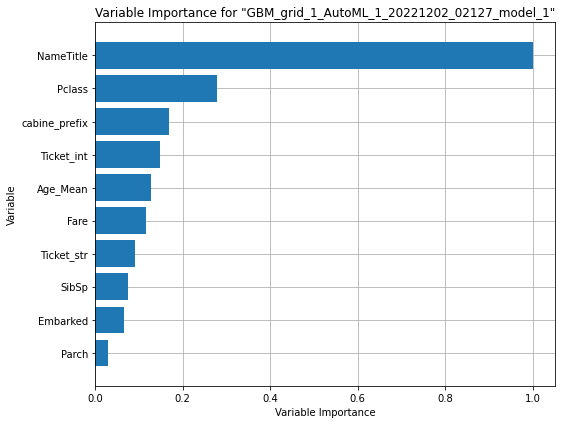

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'Ticket_str' has levels not trained on: ["SCAH"]
  warnings.warn(w)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'NameTitle' has levels not trained on: ["Countess", "Ms"]
  warnings.warn(w)


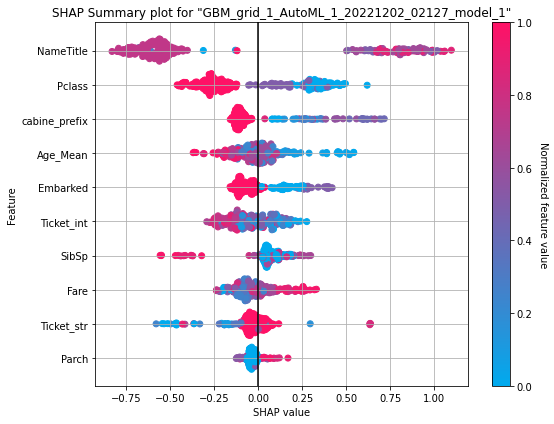

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

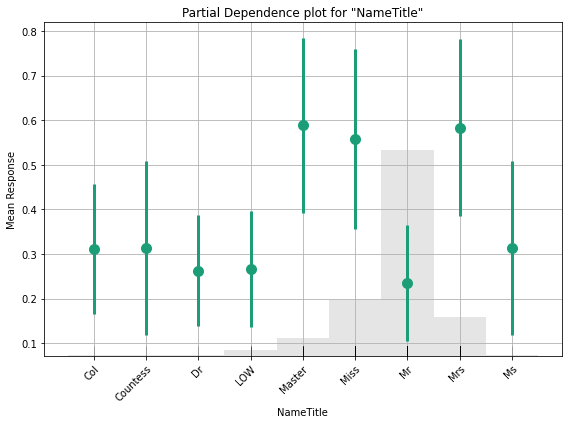

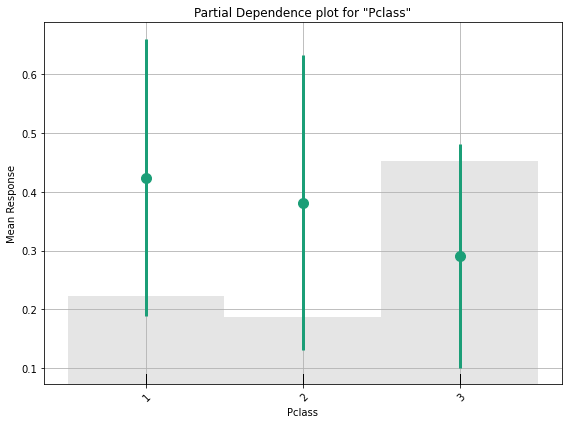

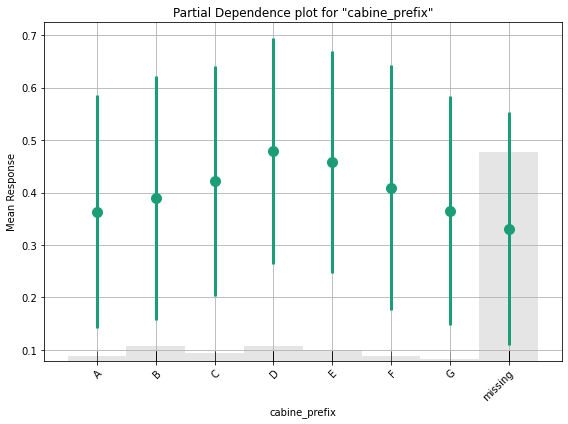

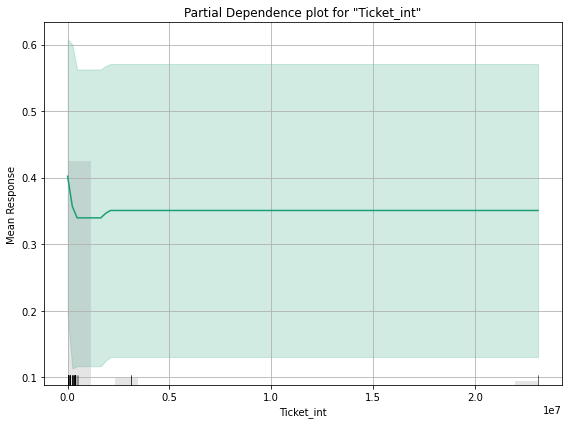

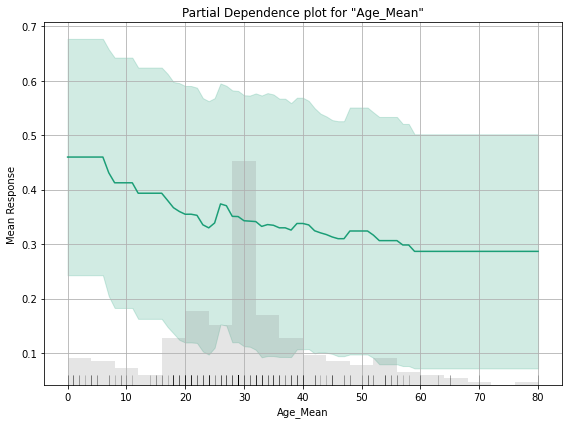

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_grid_1_AutoML_1_20221202_02127_model_1


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3305419521854348: 


,,0,1,Error,Rate
0,0,114.0,23.0,0.1679,(23.0/137.0)
1,1,19.0,64.0,0.2289,(19.0/83.0)
2,Total,133.0,87.0,0.1909,(42.0/220.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [17]:
best_AutoML.explain(frame=test_hdf, figsize=(8, 6))

## 4.3 Compare performance on the TEST dataset for all trained models

In [18]:
#Create empty model list
list_models = []

#Define the list of all models that have been executed and should be compared
try:
    list_models.append(h2o_champion)
except NameError:
    pass
try:
    list_models.append(best_AutoML)
except NameError:
    pass

In [19]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'Ticket_str' has levels not trained on: ["SCAH"]
  warnings.warn(w)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'NameTitle' has levels not trained on: ["Countess", "Ms"]
  warnings.warn(w)


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


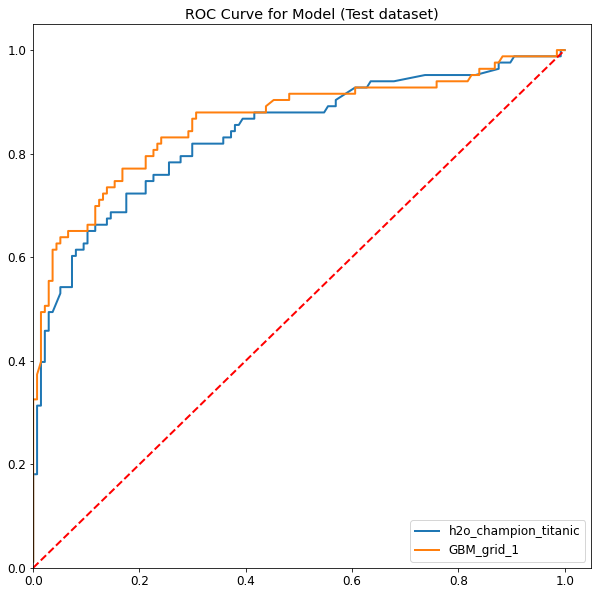

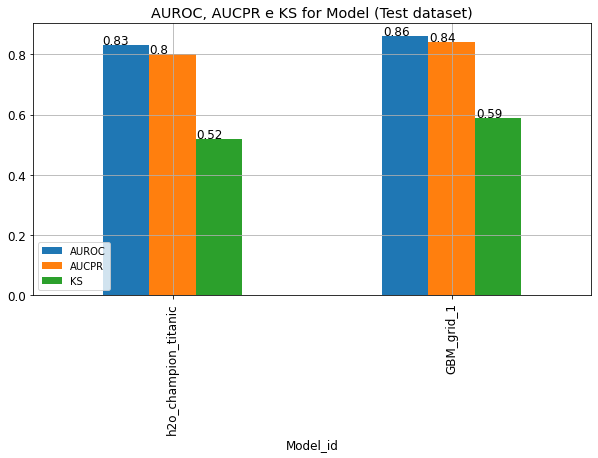

In [20]:
#Compare performance on the TEST dataset for all trained models
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10))
for i in list_models:    
    if (isinstance(i, h2o.estimators.gbm.H2OGradientBoostingEstimator)) | (isinstance(i, h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator)):
        #Save all models in H20 format
        h2o.save_model(model=i, path='%s/models/candidates/' % OutputPath, force=True)
        #calculate o KS in test dataset
        h2o_predict = i.predict(test_hdf)
        data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']    
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()

        #Ascertain the performance of all models on the test base
        performance = i.model_performance(test_hdf)

        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, i.model_id), 'w')
        f.write(
            str(i.model_id) + ";"
            + str(performance.accuracy()[0][0]) + ";"
            + str(performance.auc()) + ';'
            + str(performance.aucpr()) + ';'
            + str(performance.logloss()) + ';'
            + str(ks) + ';'
            + str(performance.F1()[0][0]))
        f.write('\n')
        f.close()

        #graph with the ROC curve of all models
        fpr = performance.fprs
        tpr = performance.tprs
        plt.plot(fpr, tpr, lw=2, label=i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2])
        plt.title("ROC Curve for Model (Test dataset)")    

        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
            
    elif isinstance(i, sagemaker.predictor.Predictor):
        #Save model
        model_id = (sm.describe_endpoint_config(EndpointConfigName=sm.describe_endpoint(EndpointName=i.endpoint_name)['EndpointConfigName'])['ProductionVariants'][0]['ModelName'])
        text_file = open("%s/models/candidates/%s.py" % (OutputPath, model_id), "w")        
        text_file.write("""#recreate create_endpoint_config and create_endpoint for model %s
epc_name = "%s"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": "%s",
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = "%s"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

sm_predictor = Predictor(
    endpoint_name="%s",
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),)""" % (model_id,
                                        model_id.replace('-model', '-epc'),
                                        model_id,
                                        model_id.replace('-model', '-ep'),
                                        model_id.replace('-model', '-ep')       
                                       )
                       )
        text_file.close()
        
        sm_predict = pd.DataFrame(i.predict(dataprep_df.query('dataset == "test"').loc[:, (selected_features)].to_csv(sep=",", header=False, index=False)))
        sm_predict.columns = ['predict', 'p1', 'probabilities']
        sm_predict['predict'] = sm_predict['predict'].astype(int)
        sm_predict['p1'] = sm_predict['p1'].astype(float)

        data = pd.concat([sm_predict.reset_index(drop=True), dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget]], axis=1)
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
        kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()
        
        accuracy = metrics.accuracy_score(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        fpr, tpr, thresholds = metrics.roc_curve(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucpr = metrics.average_precision_score(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        f1 = metrics.f1_score(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str), pos_label='1')
        log_loss = metrics.log_loss(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        
        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, model_id), 'w')
        f.write(
            str(model_id) + ";"
            + str(accuracy) + ";"
            + str(auc) + ';'
            + str(aucpr) + ';'
            + str(log_loss) + ';'
            + str(ks) + ';'
            + str(f1))
        f.write('\n')
        f.close()
        
        plt.plot(fpr, tpr, lw=2, label=model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2])
        plt.title("ROC Curve for Model (Test dataset)")
        
        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
        
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()
plt.close()
ax = df_plot.plot(kind='bar', x="Model_id", title="AUROC, AUCPR e KS for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

## 4.4 Choose the best model among all tested

In [21]:
sort_metric_best_model='AUCPR'
#import all tested models and print the 10 bests sorted by AUC on the screen
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/candidates/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'accuracy', 'AUC', 'AUCPR', 'logloss', 'KS', 'F1')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=False)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(30)

MBest Models. Sorted by : AUCPR


,index,model_id,accuracy,AUC,AUCPR,logloss,KS,F1
0,0,GBM_grid_1_AutoML_1_20221202_02127_model_1,0.532697,0.862281,0.846737,0.449322,0.596,0.330542
1,0,h2o_champion_titanic_propensity_survive_v1_20221202_002112,0.497327,0.838009,0.808254,0.483789,0.524,0.419837



BEST MODEL: GBM_grid_1_AutoML_1_20221202_02127_model_1



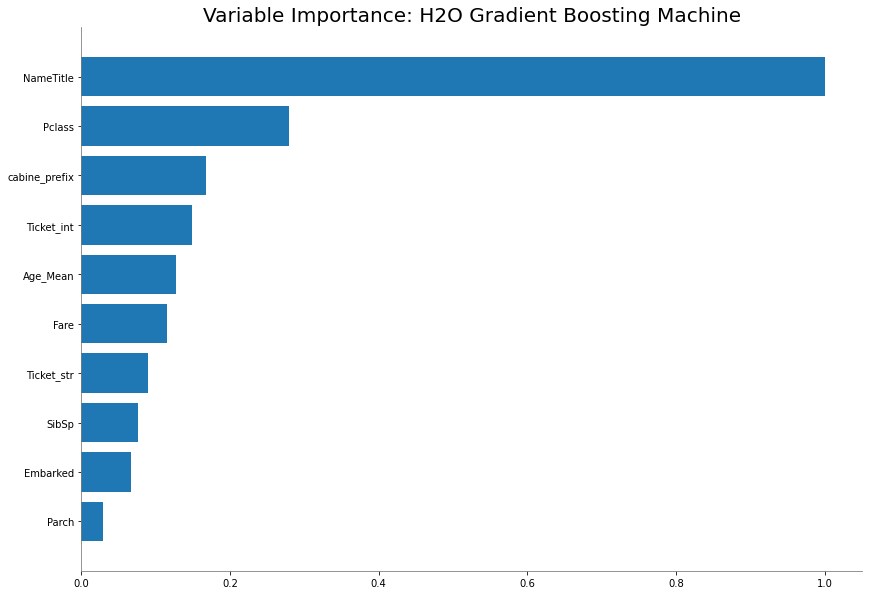

<Figure size 432x288 with 0 Axes>

In [30]:
#If you want to choose a model other than the first one on the list. Choose the position number:
posicao_melhor_modelo=0

plt.rcParams.update({'font.size': 10})
try:
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    
    melhor_modelo.varimp_plot(50)
except Exception as e:
    print(e)    
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    print("Warning: This model doesn't have variable importances")

## 4.5 Stepwise for Analysis of the importance of variables and reduce the number of variables in the best model (Only for H2O)

In [31]:
#List all variables in the current model, ordered by variable importance
#For variables defined as a factor (which possibly are like dummys), remove the category from the name and leave only the orifinal name of the variable
try:
    df_features_sorted = melhor_modelo.varimp(True).variable.str.split('.', expand=True).drop_duplicates(subset = 0)[0].reset_index(drop=True).to_list()
except Exception as e:
    #As the model with ensemble in H20 does not show the importance of variables, we will include variables in selected_features
    df_features_sorted = selected_features

In [32]:
#Define the number of variables to be increased with each new model. Try to put 10% or 20% of the total, as it can take a long time
qt_var=1
qt_total_var = len(df_features_sorted)

dict_model_tmp={}
dict_performance={}

for i in range(qt_var, qt_total_var+qt_var, qt_var):    
    df_features_sorted[0:i]
    
    #If no model chosen is not an ensemble of models. Then use the same model for training with increment of variables
    melhor_modelo_tmp = melhor_modelo
    if melhor_modelo_tmp.model_id.lower().find("ensemble") == -1:
        dict_model_tmp[i] = melhor_modelo_tmp
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)
    ##If it is not possible, for the home of an ensemble of models, use GradientBoostingEstimator to make the assessment
    else:
        dict_model_tmp[i] = H2OGradientBoostingEstimator(seed=1, model_id=str('model_tmp_%s' % i))
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)       


    perform_oot = dict_model_tmp[i].model_performance(test_hdf)
    dict_performance_tmp = {}
    dict_performance_tmp['AUC'] = {'qt_var': i, 'medida': 'AUC', 'Validation_Dataset': dict_model_tmp[i].auc(valid=True), 'testset': perform_oot.auc()}
    dict_performance_tmp['accuracy'] = {'qt_var': i, 'medida': 'accuracy', 'Validation_Dataset': dict_model_tmp[i].accuracy(valid=True)[0][0], 'testset': perform_oot.accuracy()[0][0]}
    dict_performance_tmp['AUCPR'] = {'qt_var': i, 'medida': 'AUCPR', 'Validation_Dataset': dict_model_tmp[i].aucpr(valid=True), 'testset': perform_oot.aucpr()}
    dict_performance_tmp['F1'] = {'qt_var': i, 'medida': 'F1', 'Validation_Dataset': dict_model_tmp[i].F1(valid=True)[0][0], 'testset': perform_oot.F1()[0][0]}
    dict_performance_tmp['logloss'] = {'qt_var': i, 'medida': 'logloss', 'Validation_Dataset': dict_model_tmp[i].logloss(valid=True), 'testset': perform_oot.logloss()}
    dict_performance[i] = pd.DataFrame(dict_performance_tmp).transpose()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


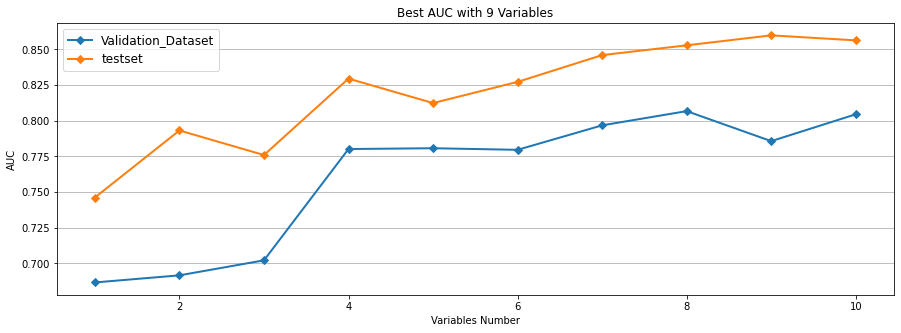

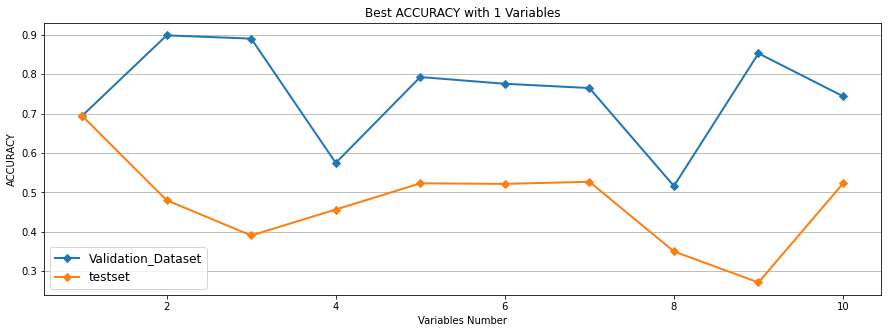

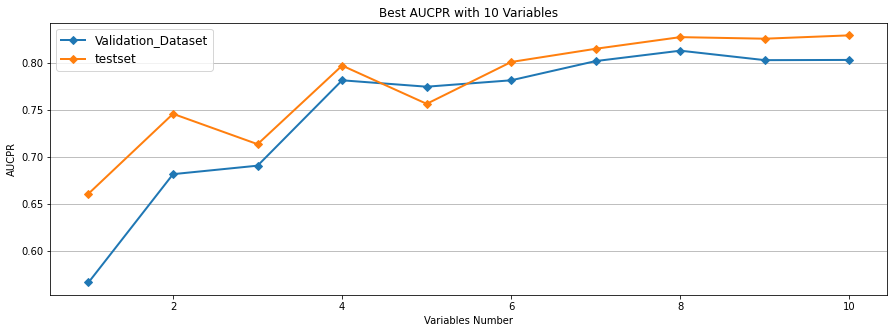

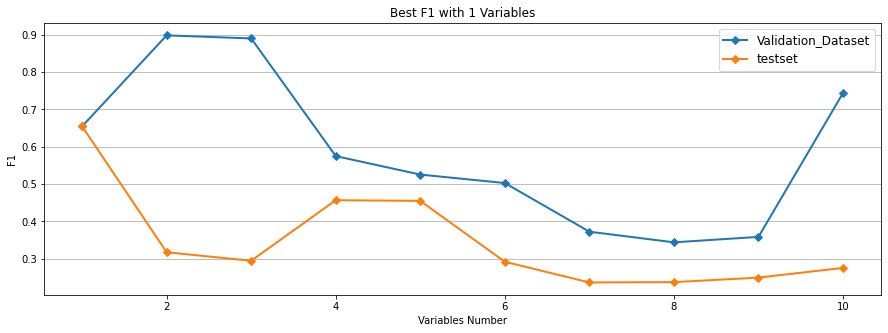

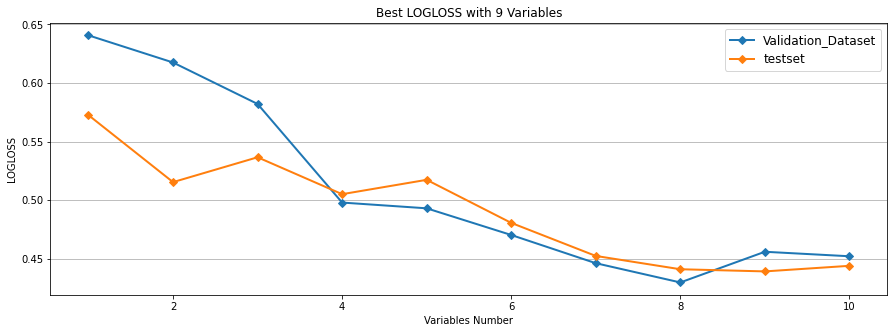

In [33]:
##Plot graph comparing the increase in performance with the increase in variables
for i in dict_performance.keys():
    if i == list(dict_performance.keys())[0]:
        df_performance = dict_performance[i]
    else:
        df_performance = df_performance.append(dict_performance[i], ignore_index=True)

lista_metricas_perf = df_performance['medida'].unique()

for i in range(len(lista_metricas_perf)):   
    #selects only the metric to be analyzed
    metrics_df_tmp = df_performance.query('medida == "%s"' % lista_metricas_perf[i])
    metrics_df_tmp = metrics_df_tmp.set_index('qt_var')
    del metrics_df_tmp['medida']
    if lista_metricas_perf[i] == 'logloss':
        max_oot = metrics_df_tmp[metrics_df_tmp['testset'] == metrics_df_tmp.testset.min()].index.values
    else:
        max_oot = metrics_df_tmp[metrics_df_tmp['testset'] == metrics_df_tmp.testset.max()].index.values
        
    if lista_metricas_perf[i] == sort_metric_best_model:
        max_oot_filtro = max_oot[0]        
    
    ax=metrics_df_tmp.plot(figsize=(15,5), linewidth=2, fontsize=10, marker='D', ms=5,\
                            title='Best %s with %s Variables' % (lista_metricas_perf[i].upper(), str(max_oot[0])))
    plt.xlabel('Variables Number')
    plt.ylabel('%s' % lista_metricas_perf[i].upper())
    plt.grid(axis='y')
    plt.legend(loc=0, prop={'size': 12})
    #display(ax)

In [34]:
print('Consider using only the following variables: '+ str(df_features_sorted[0:int(max_oot_filtro)]))

Consider using only the following variables: ['NameTitle', 'Pclass', 'cabine_prefix', 'Ticket_int', 'Age_Mean', 'Fare', 'Ticket_str', 'SibSp', 'Embarked', 'Parch']


# 5. Exporting the best model to Deploy (Usar o path_model_mojo para o código 3_Explaining_Model.ipynb)

In [35]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    print(e)

path_model_mojo: /mnt/batch/tasks/shared/LS_root/mounts/clusters/fiep-cpu1/code/Users/maxreis86/FIEP-Machine-Learning-e-Computacao-em-Nuvem/aula_01_titanic_h2o_automl/output_model/models/best/GBM_grid_1_AutoML_1_20221202_02127_model_1.zip


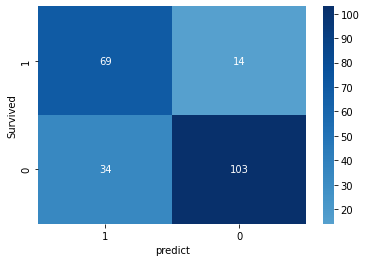

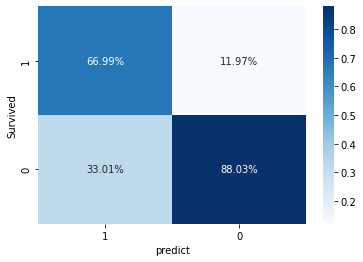

In [36]:
#Confusion Matrix for the Champion
df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])], mojo_zip_path=path_model_mojo, verbose=False)

df_predict = pd.concat([df_predict_tmp.reset_index(drop=True), dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])].reset_index(drop=True)], axis=1)

df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 6. Save final dataset with predictions to CSV

In [37]:
df_predict.to_csv('./titanic/df_predict.csv', index=False, header=True)